## Importing Libraries

In [2]:
# Importing 3rd party libraries
import os
import pandas as pd
import seaborn as sns
import matplotlib.pylab as plt
import numpy as np
import calendar
from geopy import distance
import time
import datetime as dt
import re
from pandas.api.types import CategoricalDtype

# Configuring Notebook
%matplotlib inline
plt.style.use('fivethirtyeight')
sns.set_context("notebook")
import warnings
warnings.filterwarnings('ignore')

## Importing CSV files

Let's first import the three dataframes we cleaned in file #01

In [3]:
#import ridership dataframe
date_rides = ['Start_Time', 'End_Time']
bikerides_df = pd.read_csv('bikerides_df.csv', parse_dates=date_rides)
print("done")

done


In [5]:
bikerides_df.shape

(11661157, 11)

In [6]:
#import weather dataframe
date_weather = ['Date/Time']
weather_df = pd.read_csv('weather_df.csv', parse_dates=date_weather)

In [7]:
#import stations dataframe
stations = pd.read_csv('stations.csv')

In [1]:
bikerides_df.head(2)

NameError: name 'bikerides_df' is not defined

In [9]:
weather_df.head(2)

,Longitude (x),Latitude (y),Date/Time,Year,Month,Day,Time,Temp (°C),Dew Point Temp (°C),Rel Hum (%),Wind Dir (10s deg),Wind Spd (km/h),Visibility (km),Stn Press (kPa),Hmdx,Wind Chill,Weather
0,-79.4,43.63,2017-01-01 00:00:00-05:00,2017,1,1,00:00,1.5,-3.6,69.0,26.0,39.0,16.1,99.81,NaN,NaN,Clear
1,-79.4,43.63,2017-01-01 01:00:00-05:00,2017,1,1,01:00,1.5,-3.9,67.0,27.0,35.0,16.1,100.01,NaN,NaN,Clear


In [10]:
stations.head(2)

,station_id,name,lat,lon
0,7000,Fort York Blvd / Capreol Ct,43.639832,-79.395954
1,7001,Wellesley Station Green P,43.664964,-79.383550


There are three dataframes to explore in the EDA project.
The bikerides_df is a dataframe containing ridership data for the City of Toronto between 2017 and 2021.
There are over 12 million entries in the dataframe with 11 columns containing: trip ID, trip start, end time and duration, trip start and end station name and ID, and finally User type information. User ID and bike ID are only available for 2019 and 2020 

The weather_df dataframe contains hourly weather information in the city of toronto for the years between 2017 and 2021. The weather dataframe contains 18 columns and 43,824 entries.

Lastly, the stations dataframe contains location information on the 614 bike stations in the city. It only contains 4 columns and 614 entries. The columns contain the station name and ID and latitude/longitude information. 



# bikerides_dataframe

Let's first explore the type of users. Let's explore the number of members vs casual riders.

Text(0.5, 1.0, 'Classification of total number of rides based on User type')

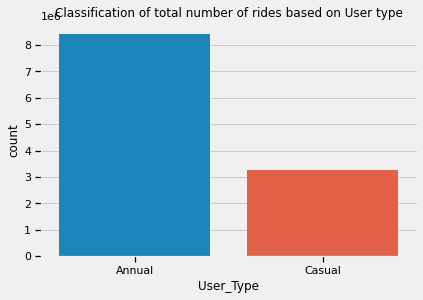

In [13]:
sns.countplot('User_Type', data=bikerides_df)
plt.title("Classification of total number of rides based on User type")

The bargraph above shows that most trips were taken by Annual members compared to casual users. 
Let's see if the same trend occurs year by year.

Let's create a sub dataframe with year, monthly and day classifications

In [16]:
days = [(dt.datetime(2019, 3, 4) + dt.timedelta(days=x)).strftime('%a') for x in range(0, 7)]
day_type = CategoricalDtype(categories=days, ordered=True)
# Create the month Category by iterrating over the months
months = [dt.datetime(2019, x, 1).strftime('%B') for x in range(1, 13)]
month_type = CategoricalDtype(categories=months, ordered=True)
print('done')

done


In [17]:
#Create a sub-dataframe that extracts time values into new columns
bikerides_df_sub1 = bikerides_df[["ID", "User_Type", "Start_Time", "Duration"]]
bikerides_df_sub1['Year'] = bikerides_df_sub1['Start_Time'].dt.year
bikerides_df_sub1["Month"] = bikerides_df_sub1.apply(lambda row: calendar.month_name[row["Start_Time"].month] ,axis = 1)
bikerides_df_sub1['Day'] =  bikerides_df_sub1['Start_Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
bikerides_df_sub1['hour'] = bikerides_df_sub1['Start_Time'].dt.hour
bikerides_df_sub1["Day_of_month"] = bikerides_df_sub1['Start_Time'].dt.day
#Set start_time as index
bikerides_df_sub1 = bikerides_df_sub1.set_index('Start_Time')

#Add a column representating workday vs weekend
workday = []
for i in range(bikerides_df_sub1.shape[0]):
    if bikerides_df_sub1.index[i].weekday() < 5:
        is_workday = True
    else:
        is_workday = False
    workday.append(is_workday)
    
bikerides_df_sub1['Workday'] = workday

#create a pivot table to see the total number of Annual members vs casual members
bikerides_df_pivot = pd.pivot_table(bikerides_df_sub1, values='ID',  index='Year', columns='User_Type',
               aggfunc='count', margins=True)


bikerides_df_pivot

User_Type,Annual,Casual,All
Year,,,
2016,57,1,58
2017,1136352,257369,1393721
2018,1557286,285632,1842918
2019,1848731,510862,2359593
2020,1853010,917546,2770556
2021,2014588,1279723,3294311
All,8410024,3251133,11661157


In [18]:
bikerides_df_sub1.shape

(11661157, 9)

Text(0.5, 1.0, 'Total number of trips per year')

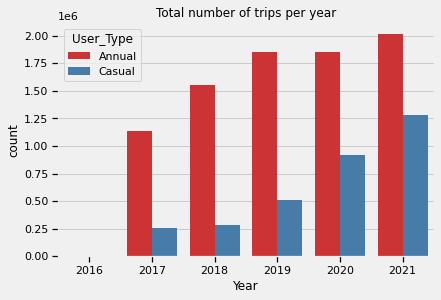

In [27]:
# create a countplot to show number of trip per year
ax = sns.countplot(x="Year", data=bikerides_df_sub1, palette="Set1", hue = "User_Type")
plt.title("Total number of trips per year")

The data shows that there are more Annual members in the city compared to casual riders each year. Both Annul and Casual members show a steady increase, however casual members are showing a rapid increase in the years of 2020 and 2021.

However, this does not reflect the ridership behaviour.
Let's further investigate who uses the bikes more and the behaviour of their ridership.


#### Distribution of Number of rides for Annual Members and Casual Members
A deeper explotary analysis for the duration of each type of users. 

User_Type,Annual,Casual
Year,,
2016,579.210526,474.000000
2017,650.993670,988.167841
2018,678.349261,1081.660997
2019,674.900392,1066.438784
2020,747.932861,1086.809423
2021,734.821301,973.762835


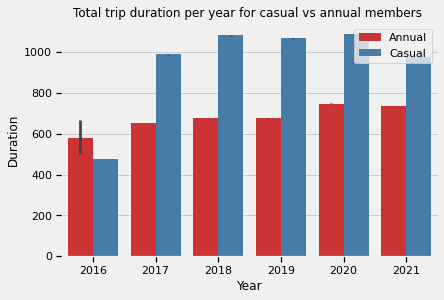

In [31]:
bikerides_df_duration_pivot = pd.pivot_table(bikerides_df_sub1, values='Duration',  index='Year', columns='User_Type',
               aggfunc='mean')

ax = sns.barplot(x="Year", y="Duration", data=bikerides_df_sub1, palette="Set1", hue = "User_Type")
ax.legend(loc=1)
plt.title('Total trip duration per year for casual vs annual members ')


bikerides_df_duration_pivot

Notice that trip duration varies between casuals and annual members. Casuals seem to keep their bikes longer. 

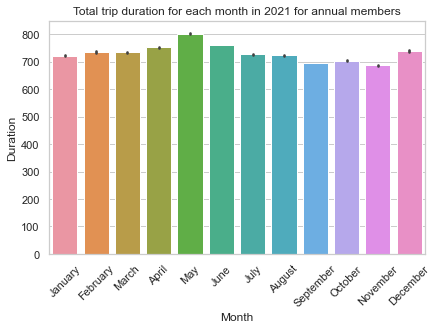

In [84]:
# annual 2021 trip duration
bikerides_df_sub_2021 = bikerides_df_sub1[(bikerides_df_sub1["Year"] == 2021) & (bikerides_df_sub1['User_Type'] == "Annual")]

ax = sns.barplot(x="Month", y="Duration", data=bikerides_df_sub_2021   ,  order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
plt.xticks(rotation=45)
plt.ylim(0, 850)
plt.title('Total trip duration for each month in 2021 for annual members');

The average trip hovers between 11.5 minutes and 13 minutes for each month. Notice that the introduction of the 45 minutes membership on June 2021 had no effect in average trip duration.
A month to month comparison with 2022 data might reveal a difference in trip duration but data is not yet available for 2022.


Let's analyze what happens in a monthly basis.
This will give us an idea of how the bikes are used through out the five years

...

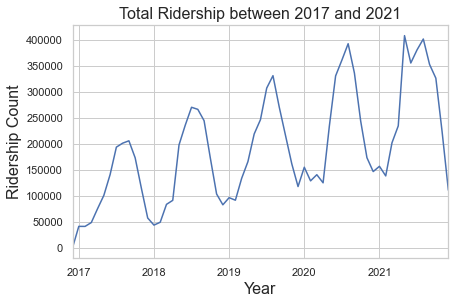

In [85]:
#compute total ridership count for each month throughout 2017 to 2021
bikerides_df_sub1["ID"].resample('M').count().plot()
plt.grid(True) 
plt.xlabel('Year',  fontsize = 16)
plt.ylabel('Ridership Count',  fontsize = 16);
plt.title('Total Ridership between 2017 and 2021',  fontsize = 16);

The data shows a steady growth in the number of ridership. 



Let's compare each year against each other

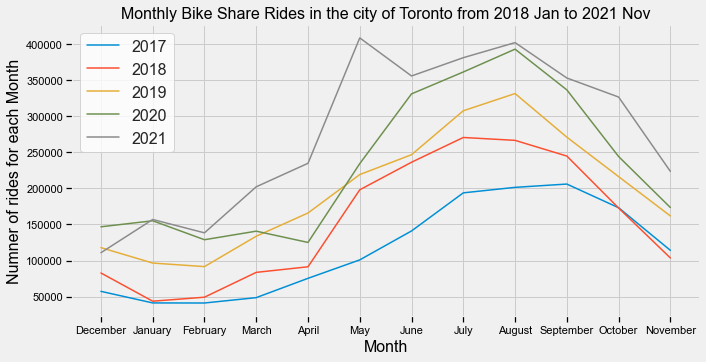

In [38]:
df_ride_number = bikerides_df_sub1.resample("m").count().reset_index("Start_Time")
df_ride_number["Month"] = df_ride_number.apply(lambda row: calendar.month_name[row["Start_Time"].month] ,axis = 1)
#Monthly Graph

plt.figure(figsize =(10,5))
plt.title('Monthly Bike Share Rides in the city of Toronto from 2018 Jan to 2021 Nov', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.lineplot(
    x = df_ride_number["Month"],
    y = df_ride_number[df_ride_number["Start_Time"].dt.year == 2017]["Duration"],
    markers=False)
ax = sns.lineplot(
    x = df_ride_number["Month"],
    y = df_ride_number[df_ride_number["Start_Time"].dt.year == 2018]["Duration"],
    markers=False)
ax = sns.lineplot(
    x = df_ride_number["Month"],
    y = df_ride_number[df_ride_number["Start_Time"].dt.year == 2019]["Duration"],
    markers=False)
ax = sns.lineplot(
    x = df_ride_number["Month"],
    y = df_ride_number[df_ride_number["Start_Time"].dt.year == 2020]["Duration"],
    markers=False)
ax = sns.lineplot(
    x = df_ride_number["Month"],
    y = df_ride_number[df_ride_number["Start_Time"].dt.year == 2021]["Duration"],
    markers=False)

plt.grid(True)
plt.xlabel('Month',  fontsize = 16)
plt.ylabel('Numner of rides for each Month',  fontsize = 16);
plt.legend(['2017', '2018', '2019', '2020', '2021'],  fontsize = 16);

The graph above showsa year by year increase of total ridership.

This includes both user types: casual riders and annual members. Its important to note that the increase in ridership aligns with the city’s expansion targets in number of bikes and stations across the city
The data reveals a steady increase in ridership year by year. 

Number of trips increased by 20% in 2020 compared to the year before, and then also increased by another 20% in 2021.
The reason for this increase in ridership is mainly associated to lockdowns due to the pandemic.

We know that Toronto’s lockdowns were one of the longest in the world.
We can see in the chart a significant increase in ridership in June of 2020 and May 2021.

An interesting observation is the one for  2021 as the number of trips have a jump in May resembling an outlier but we believe that this aligns well with the short lockdown we had in the city between April and end of May.


The above graphs also shows the annual ridership per month for the years of 2017 -2018
From this graph, we could see that majority of ridership is in the summer months. But do Annual members use thier membership every day throughout the year or they use it only in the summer season more often? Do casual members use the bikes more often in summer months??

#### Seasonal Ridership

In [91]:
#extract season from start_time
bikerides_df_sub1 = bikerides_df_sub1.reset_index()
bikerides_df_sub1['season'] = (bikerides_df_sub1['Start_Time'].dt.month%12 + 3)//3

seasons = {
             1: 'Winter',
             2: 'Spring',
             3: 'Summer',
             4: 'Fall'
}

bikerides_df_sub1['season_name'] = bikerides_df_sub1['season'].map(seasons)

In [ ]:
bikerides_df_sub1.head(2)

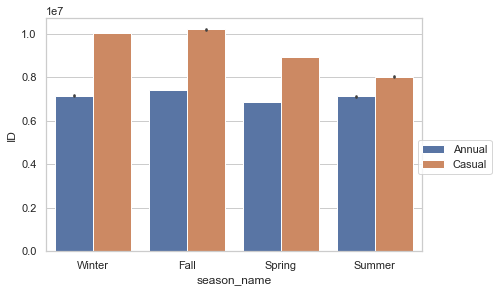

In [95]:
sns.barplot(x = 'season_name', y = 'ID', hue = 'User_Type', data = bikerides_df_sub1).legend(bbox_to_anchor=(1.2, 0.5))

The barplot shows the bikshare ridership per season.

A further daily analysis is provided in the next four barplots

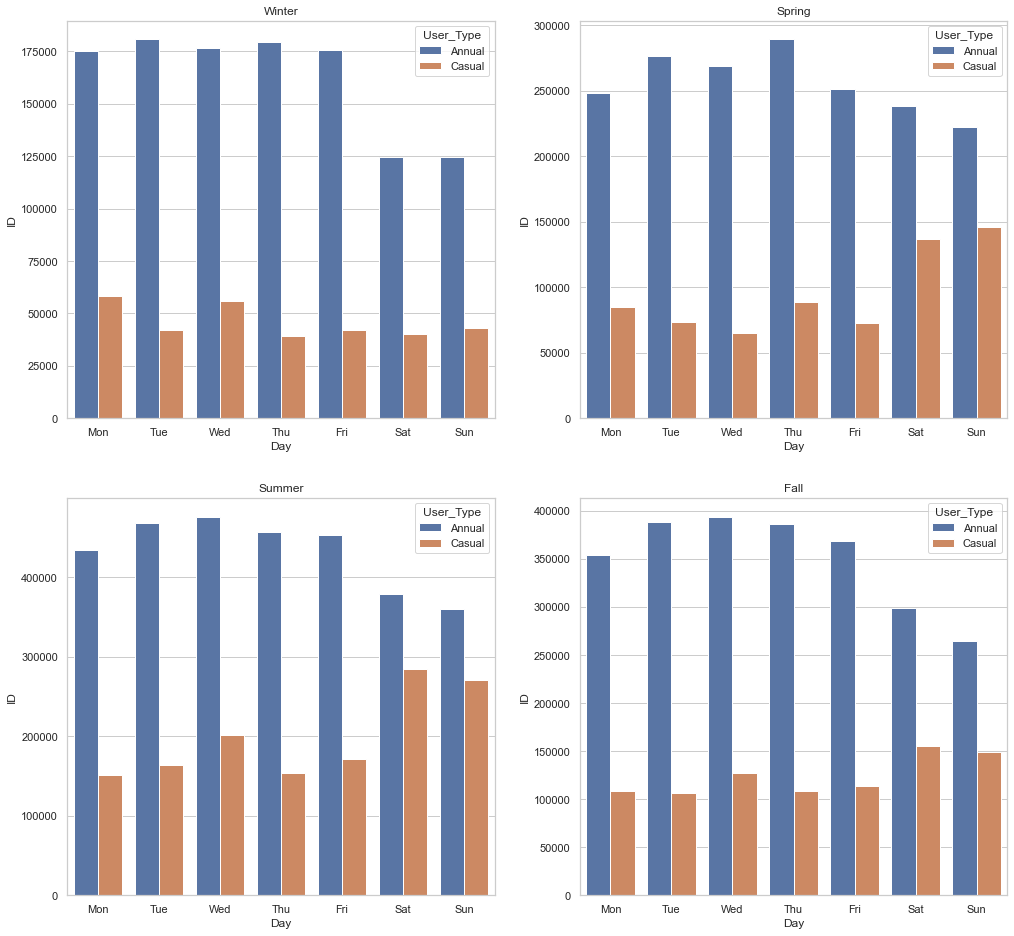

In [96]:
'''
Code was created from - https://github.com/open-data-toronto/story-bike-share-ridership/blob/master/bikeshare.ipynb
Using 
'''
fig, axes = plt.subplots(2, 2, figsize=(15, 15))

axes = np.array(axes).flatten()
quarter_names = ['Winter', 'Spring', 'Summer', 'Fall']

for q, ax in zip(sorted(bikerides_df_sub1['season'].unique()), axes):
    ax.set_title(quarter_names[(q-1)])
  
    ax.set_ylabel('Average Daily Trips')
    sns.barplot(
        x='Day', y='ID',  hue='User_Type',
        data=bikerides_df_sub1[bikerides_df_sub1['season']==q].groupby(['Day', 'User_Type'])['ID'].count().reset_index(),ax=ax)

So looking at the seasonal ridership across all 5 years,for obvious reasons, 
winter has the lowest ridership while summer has the highest demand for both user types. 
However what is interesting is the ratio of trips taken by casual to annual members per season. 
We see a huge reduction in casual riders in winter
As the percentage of casual ridership is only about 25% of that annual member while that number might reach up to 60% in the summer.

What might this mean?
Although general usage drops in winter, the rate of decrease is much higher for casuals who might not think its worth it to pay the casual fee in winter.

Similarly, monthly, daily and hourly analysis of ridership is provided below.
Looking at the ridership in a monthly basis compared to seasonal helps pin-point the exact month ridership starts to pickup.

<AxesSubplot:xlabel='hour', ylabel='count'>

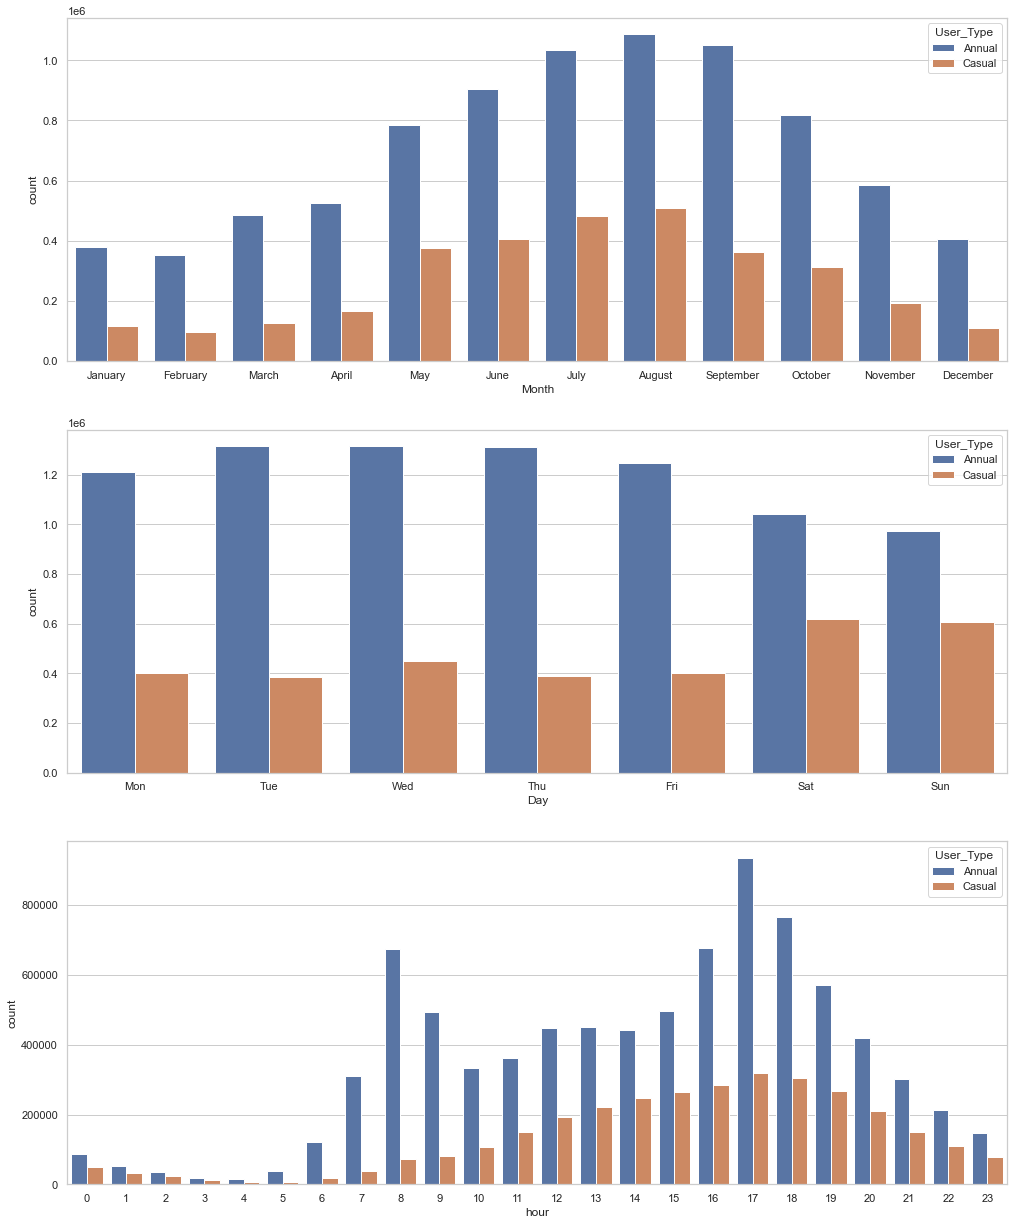

In [98]:
figure, ((ax1,ax2,ax3)) = plt.subplots(nrows=3, ncols =1)
figure.set_size_inches(15,20)

sns.countplot(data=bikerides_df_sub1, x = 'Month', hue = 'User_Type', ax = ax1,  order=['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October', 'November', 'December'])
sns.countplot(data=bikerides_df_sub1, x = 'Day', hue = 'User_Type', ax = ax2)
sns.countplot(data=bikerides_df_sub1, x = 'hour', hue = 'User_Type', ax = ax3)

The first graph shows that riders starts to pick up in April for both types of user. 

And that monthly ridership keeps increasing until it reaches its peak on August. It seems from the monthly visualization that both user types share similar bike riding behaviour but then a quick look a the daily figure we see a different story.

It’s clear that the daily behaviour is completely opposite between both user types. 

Annual members tend to ride more on weekdays while casual riders tend to use the bikeshare program more on the weekends. 
A key reason is the fact that annual members acquire the membership mainly for ther daily commute (going back and forth from home to work).

However, casual riders include locals or residents from around the GTA area using the bikes for leisure on weekends. Not to mention tourists who account for a big portion of trips by casual users. 

Lastly, the hourly data aligns with previous hypothesis.. we see a rise in trips by annual members during the (am and pm) rush hours indicating commute trips. While we kinda see a normal distribution for casual members around the evening time (where people usually go out for leisure activities). 

In [99]:
#sub daily ridership by time of day
daily_activity = bikerides_df_sub1.groupby(by=['Day','hour']).count()['ID'].unstack()
daily_activity.head()

hour,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Day,,,,,,,,,,,,,,,,,,,,,
Mon,15491,8706,5574,3119,2940,7263,22433,56462,121277,83598,...,84656,96058,131330,187096,157932,121073,89405,63009,42280,27418
Tue,15577,8515,5286,2871,2900,7301,24432,61311,132530,92240,...,84451,97397,137706,199046,166125,125965,94403,67498,46614,30796
Wed,17012,9207,5682,2896,2956,7593,24635,63100,136983,94537,...,86832,99131,140360,207357,174656,134178,100382,72915,50563,32396
Thu,17830,9602,5971,3056,2951,7561,24380,63123,139747,99918,...,83625,96510,134015,192399,161379,121864,91819,65501,46964,32829
Fri,18990,11251,7432,3758,3308,6831,21678,55706,121899,90077,...,91421,104991,139000,176417,145704,112680,83647,62184,46641,36416


Text(0.5, 1.0, 'Heatmap for hourly ridership by day of week')

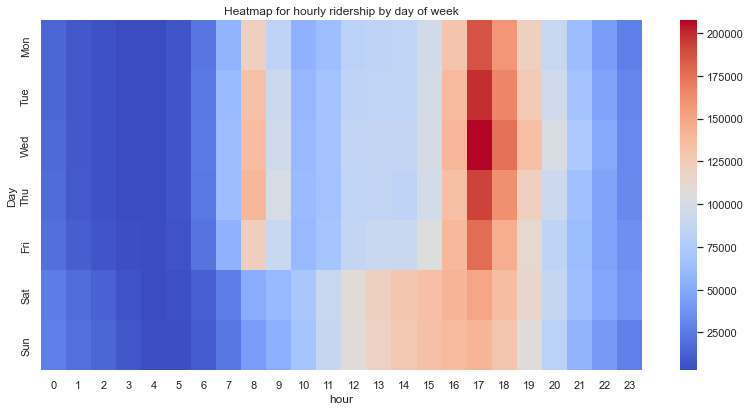

In [100]:
#heat meap visualization fr the hourly ridership per day for both users
plt.figure(figsize=(12,6))
sns.heatmap(daily_activity, cmap='coolwarm')
plt.title("Heatmap for hourly ridership by day of week")

Text(0.5, 1.0, 'Heatmap for hourly ridership by day of week for casual riders')

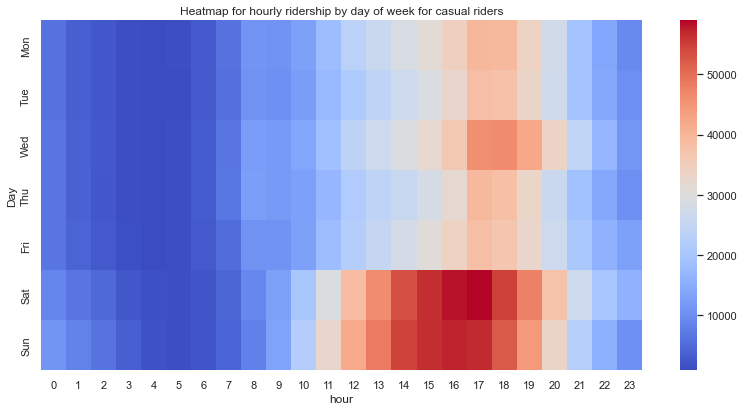

In [101]:
#Casual members heatmap
bikerides_df_sub1_casual = bikerides_df_sub1[(bikerides_df_sub1["User_Type"] == "Casual")]
daily_activity_casual = bikerides_df_sub1_casual.groupby(by=['Day','hour']).count()['ID'].unstack()



plt.figure(figsize=(12,6))
sns.heatmap(daily_activity_casual, cmap='coolwarm')
plt.title("Heatmap for hourly ridership by day of week for casual riders")

Text(0.5, 1.0, 'Heatmap for hourly ridership by day of week for annual members')

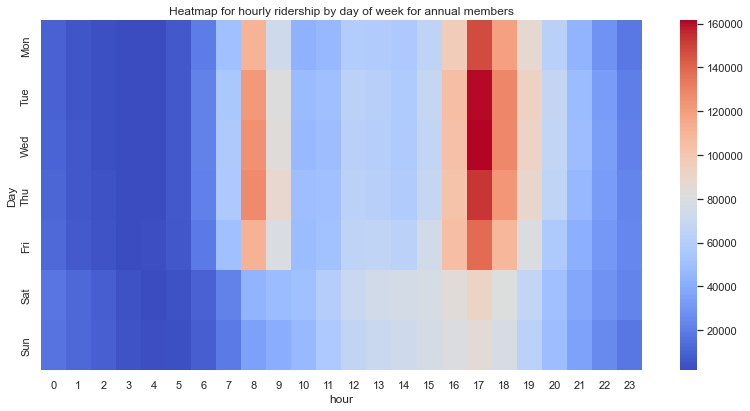

In [102]:
#Annual members heatmap
bikerides_df_sub1_annual = bikerides_df_sub1[(bikerides_df_sub1["User_Type"] == "Annual")]
daily_activity_annual = bikerides_df_sub1_annual.groupby(by=['Day','hour']).count()['ID'].unstack()



plt.figure(figsize=(12,6))
sns.heatmap(daily_activity_annual, cmap='coolwarm')
plt.title("Heatmap for hourly ridership by day of week for annual members")

The monthly ridership shows an increase in june, july, august and september. This seems to be affected by the summer months. However, we also see a steady annual ridership between January and May, while casual members have very low riderships during the same months.



The daily analysis shows a significant difference between annual members and casual riders.
As annual members seem to b riding more during workdays, casual members show an icrease in ridership during the weekend. Although there might be multiple factors involved, the main factor is that casual members use the bikes for leisure/tourists while annual members include daily commuters going to work by bike.




Both user types share hourly usage with the highest volumes concnetrated between 5pm and 7pm.
However, a big surchage could be seen amongst annual members between 8am and 9am (an expected daily for a daily commuter going to work)


#### Distance between stations per trip

Let's add a new column to measure the distance between start_station and end_station.
For this we need the Station dataframe to extract the lat/lon information for each station. This analysis assumes trip are taken between each station using the shortest distance between the start_station and end_station

First let's create an origin and a destination dataframe using the stations dafarame

In [106]:
stations_origin = stations.rename(columns= {'station_id':'origin_id', 'name':'origin_name', 'lat': 'origin_lat', 'lon':'origin_lon'})
stations_dest = stations.rename(columns= {'station_id':'dest_id', 'name':'dest_name', 'lat': 'dest_lat', 'lon':'dest_lon'})
print("done")

done


Now let's merge the two dataframes with our ridership dataframe

In [107]:
stations_rideshare_df = bikerides_df.merge(stations, left_on = "Start_Station_name", right_on ="name", how = "left").merge(stations, left_on = "End_Station_name", right_on ="name", how = "left")
stations_rideshare_df.head(2)

,ID,Start_Time,End_Time,Duration,Start_Station_id,Start_Station_name,End_Station_id,End_Station_name,User_Type,Subscription Id,Bike Id,station_id_x,name_x,lat_x,lon_x,station_id_y,name_y,lat_y,lon_y
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual,NaN,NaN,7006.0,Bay St / College St (East Side),43.660439,-79.385525,7021.0,Bay St / Albert St,43.653264,-79.382458
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Annual,NaN,NaN,7046.0,Niagara St / Richmond St W,43.645340,-79.409597,7147.0,King St W / Fraser Ave,43.639444,-79.425278


Next, drop the station_id (x and y) and station_name (x and y) and rename latx, lon_x and lat_y and lon_y for easier visualization. Similarly drop subscription id and bike id as this analysis is on stations

In [108]:
#Rename lat and lon
stations_rideshare_df = stations_rideshare_df.rename(columns={'lat_x': 'Start_station_lat', 'lon_x': 'Start_station_lon', 'lat_y': 'End_station_lat', 'lon_y': 'End_station_lon'})

#drop duplicate columns
stations_rideshare_df = stations_rideshare_df.drop(['station_id_x', 'name_x', 'station_id_y', 'name_y', 'Subscription Id', 'Bike Id'], axis=1)

In [109]:
stations_rideshare_df.isnull().sum()

ID                          0
Start_Time                  0
End_Time                    0
Duration                    0
Start_Station_id            3
Start_Station_name       3222
End_Station_id           3427
End_Station_name         6724
User_Type                   0
Start_station_lat     1037742
Start_station_lon     1037742
End_station_lat       1044096
End_station_lon       1044096
dtype: int64

Drop null values. These are the stations we were not able to find their location info. 
It accounts to less than 10% of the total data.

In [110]:
stations_rideshare_df = stations_rideshare_df.dropna()

In [45]:
stations_rideshare_df.shape

(9756441, 13)

In [111]:
# Add a route column
stations_rideshare_df['route'] = stations_rideshare_df.apply(lambda x: '{0}-{1}'.format(int(x['Start_Station_id']), int(x['End_Station_id'])), axis=1)

In [112]:
# Extract the unique routes from the data with their start and end coordinates
Routes = stations_rideshare_df[['ID', 'Start_Time', 'End_Time', 'Duration', 'route', 'Start_Station_name', 'End_Station_name', 'Start_Station_id', 'Start_station_lat', 'Start_station_lon', 'End_Station_id', 'End_station_lat', 'End_station_lon', 'User_Type']].drop_duplicates()

In [113]:
#change the dtype for lat/lon data
Routes['Start_station_lat'] = Routes['Start_station_lat'].astype('float')
Routes['End_station_lat'] = Routes['End_station_lat'].astype('float')
Routes['Start_station_lon'] = Routes['Start_station_lon'].astype('float')
Routes['End_station_lon'] = Routes['End_station_lon'].astype('float')
print("done")

done


In [49]:
Routes.head(2)

,ID,Start_Time,End_Time,Duration,route,Start_Station_name,End_Station_name,Start_Station_id,Start_station_lat,Start_station_lon,End_Station_id,End_station_lat,End_station_lon,User_Type
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006-7021,Bay St / College St (East Side),Bay St / Albert St,7006.0,43.660439,-79.385525,7021.0,43.653264,-79.382458,Annual
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046-7147,Niagara St / Richmond St W,King St W / Fraser Ave,7046.0,43.645340,-79.409597,7147.0,43.639444,-79.425278,Annual


In [ ]:
#verify this code
time_dist = time.time()
Routes['distance'] = (Routes.apply(lambda x: distance.distance((x['Start_station_lat'], x['Start_station_lon']), (x['End_station_lat'], x['End_station_lon'])), axis = 1))

time_dist_end = time.time()
print("Time to measure distance:", (time_dist_end - time_dist), "sec")

In [51]:
#Create a new column showing distance between each station in kms.
Routes['distance'] = Routes['distance'].astype(str).str[:-3].astype(float)

In [ ]:
Routes['Start_Time'] = pd.to_datetime(Routes['Start_Time'])
Routes['End_Time'] = pd.to_datetime(Routes['End_Time'])

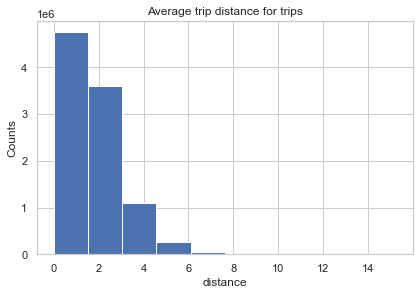

In [60]:
# plot a countplot to see the count of trip distance.
plt.hist(Routes['distance'])
plt.title("Average trip distance for trips")
plt.xlabel('distance')
plt.ylabel('Counts')
plt.show()

In [59]:
print('done')

done


This shows that most trips are under 3 kms.

We've seen that casual members' trips are longer in duration compared to annual members.
Let's explore the same comparison with respect to distance.

NameError: name 'Routes' is not defined

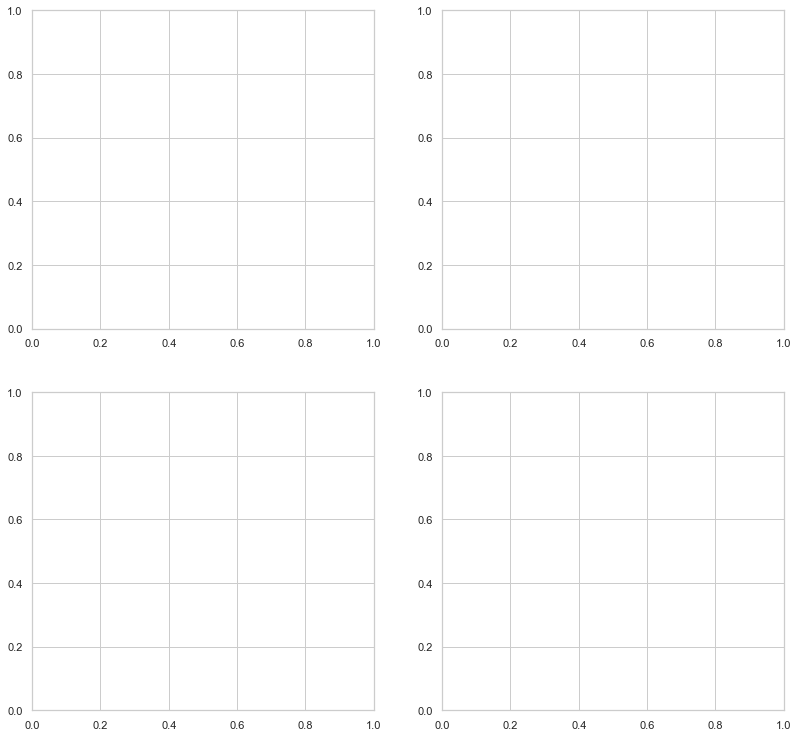

In [72]:
#trip duration vs ditance for annual vs casual members
fig, (ax1, ax2) = plt.subplots(2, 2, figsize=(12, 12))
for i, col in enumerate(['Duration', 'Distance']):
    # distplot
    for j, user in enumerate(Routes['User_Type'].unique()):
        sns.distplot(Routes[Routes['User_Type'] ==user][col], hist=False, ax=ax2[i])
        fig.legend(labels=['Annual','Casual'])
    # box plot
    sns.boxplot(x=col, y='User_Type', data=Routes, ax=ax1[i])
    ax1[i].set_xlabel('')

From the above box and distplots, we see that although casual members use their bikes longer, there is not significant difference in the distance of each trip between both types of users. 

### bike Id and Subscription ID

In order to understand the behaviour of riders and subscribers, a further analysis is done solely for the years of 2019 and 2020 as they contain bike_identification and subscriber id

Similar to the previous approach, lets create a sub dataframe for the years of 2019 and 2020 only.

In [71]:
df_subID = bikerides_df[(bikerides_df['Start_Time'].dt.year == 2020) | (bikerides_df['Start_Time'].dt.year == 2019) ]
print('done')

done


In [62]:
df_subID["End_Station_id"] = df_subID["End_Station_id"].astype('Int64')
df_subID["Subscription Id"] = df_subID["Subscription Id"].astype('Int64')
df_subID["Bike Id"] = df_subID["Bike Id"].astype('Int64')
df_subID["Year"] = df_subID["Start_Time"].dt.year
df_subID["Month"] = df_subID["Start_Time"].dt.month
df_subID['Day'] =  df_subID['Start_Time'].apply(lambda x: x.strftime('%a')).astype(day_type)
df_subID["Day_of_month"] = df_subID['Start_Time'].dt.day

#view sub dataframe
df_subID.head(2)

,ID,Start_Time,End_Time,Duration,Start_Station_id,Start_Station_name,End_Station_id,End_Station_name,User_Type,Subscription Id,Bike Id,Year,Month,Day,Day_of_month
3236697,4581278,2019-01-01 00:08:00-05:00,2019-01-01 00:33:00-05:00,1547,7021.0,Bay St / Albert St,7233,King / Cowan Ave - SMART,Annual,199751,1296,2019,1,Tue,1
3236698,4581279,2019-01-01 00:10:00-05:00,2019-01-01 00:29:00-05:00,1112,7160.0,King St W / Tecumseth St,7051,Wellesley St E / Yonge St (Green P),Annual,294730,2947,2019,1,Tue,1


In [63]:
df_subID_number = df_subID[["User_Type", "Subscription Id", "Start_Time", "Year"]].groupby(
    ["User_Type", "Subscription Id", "Year"]).count().reset_index().groupby(["Year", "User_Type"]).count().reset_index().drop(
    "Start_Time", axis =1).rename(columns={"Subscription Id": "Number"})
df_subID_number

,Year,User_Type,Number
0,2019,Annual,23819
1,2019,Casual,161693
2,2020,Annual,24826
3,2020,Casual,260010


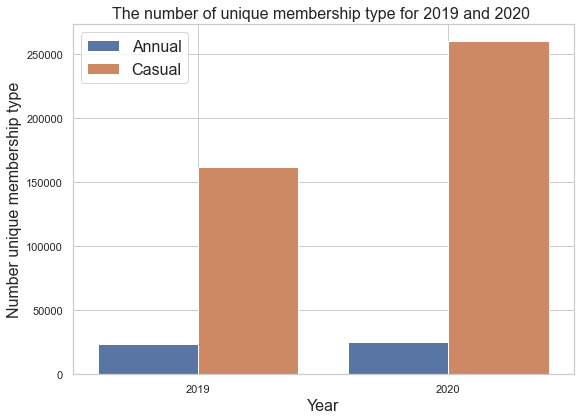

In [64]:
plt.figure(figsize =(8,6))
plt.title('The number of unique membership type for 2019 and 2020 ', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = "Year", y="Number", hue = "User_Type", data = df_subID_number)
plt.grid(True)
plt.xlabel('Year',  fontsize = 16)
plt.ylabel('Number unique membership type',  fontsize = 16);
plt.legend( fontsize = 16);
plt.show();

#### Distribution of Number of used days for Annual  and casual Members


The following visualization shows the number of days Annual members used their membership. This is only made for 2019 and 2020 as mentioned becuase it is the only years subscription data avaialable.

In [65]:
#Create a sub dataframe based on subscription id for annual members for 2019 and 2020

df_subID_days_annual_2019 = df_subID[(df_subID["Year"] == 2019) & (df_subID["User_Type"] == "Annual") ][[ "Subscription Id", "Start_Time", "Duration"]].set_index(
    "Start_Time").groupby(["Subscription Id"]).resample("d")["Duration"].sum().reset_index().groupby(
    "Subscription Id").count().reset_index().drop("Start_Time", axis = 1).rename(columns={"Duration":"Days"})

df_subID_days_annual_2020 = df_subID[(df_subID["Year"] == 2020) & (df_subID["User_Type"] == "Annual") ][[ "Subscription Id", "Start_Time", "Duration"]].set_index(
    "Start_Time").groupby(["Subscription Id"]).resample("d")["Duration"].sum().reset_index().groupby(
    "Subscription Id").count().reset_index().drop("Start_Time", axis = 1).rename(columns={"Duration":"Days"})

print('done')

done


In [68]:
#Create a sub dataframe based on subscription id for casual members for 2019 and 2020

df_subID_days_casual_2019 = df_subID[(df_subID["Year"] == 2019) & (df_subID["User_Type"] == "Casual") ][[ "Subscription Id", "Start_Time", "Duration"]].set_index(
    "Start_Time").groupby(["Subscription Id"]).resample("d")["Duration"].sum().reset_index().groupby(
    "Subscription Id").count().reset_index().drop("Start_Time", axis = 1).rename(columns={"Duration":"Days"})

df_subID_days_casual_2020 = df_subID[(df_subID["Year"] == 2020) & (df_subID["User_Type"] == "Casual") ][[ "Subscription Id", "Start_Time", "Duration"]].set_index(
    "Start_Time").groupby(["Subscription Id"]).resample("d")["Duration"].sum().reset_index().groupby(
    "Subscription Id").count().reset_index().drop("Start_Time", axis = 1).rename(columns={"Duration":"Days"})

print('done')

KeyboardInterrupt: 

In [70]:

df_subID_days_casual_2020 = df_subID[(df_subID["Year"] == 2020) & (df_subID["User_Type"] == "Casual") ][[ "Subscription Id", "Start_Time", "Duration"]].set_index(
    "Start_Time").groupby(["Subscription Id"]).resample("d")["Duration"].sum().reset_index().groupby(
    "Subscription Id").count().reset_index().drop("Start_Time", axis = 1).rename(columns={"Duration":"Days"})

KeyboardInterrupt: 

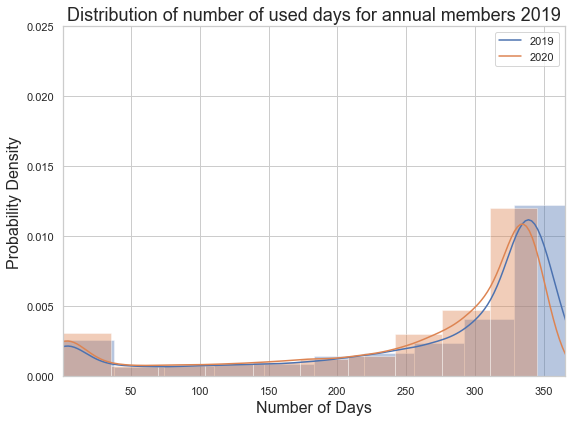

NameError: name 'df_subID_days_casual_2020' is not defined

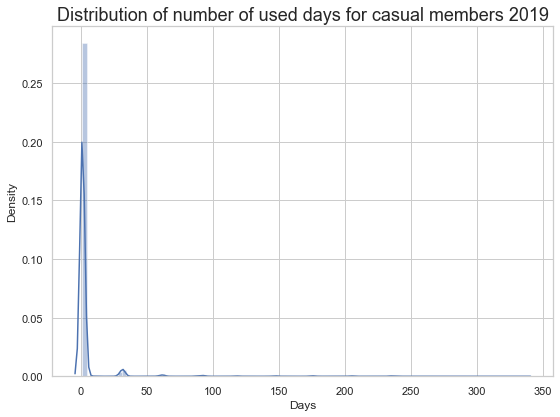

In [71]:
#plot the number of days for annual members 

plt.figure(figsize =(8,6))
plt.title('Distribution of number of used days for annual members 2019', fontsize = 18)
sns.set_theme(style="whitegrid")
ax1 = sns.distplot(df_subID_days_annual_2019["Days"], rug=False, bins = 10)
ax1 = sns.distplot(df_subID_days_annual_2020["Days"], rug=False, bins = 10)

plt.xlabel('Number of Days',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
plt.xlim([1,365])
plt.ylim([0,0.025]);
plt.legend(["2019", "2020"])
plt.show();


plt.figure(figsize =(8,6))
plt.title('Distribution of number of used days for casual members 2019', fontsize = 18)
sns.set_theme(style="whitegrid")


ax2 = sns.distplot(df_subID_days_casual_2019["Days"], rug=False, bins = 100)
ax2 = sns.distplot(df_subID_days_casual_2020["Days"], rug=False, bins = 10)

plt.xlabel('Number of Days',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
plt.xlim([1,20])
# plt.ylim([0,0.025]);
plt.legend(["2019", "2020"])
plt.show();

In [72]:
print('done')

done


This is interesting findings. Most Annual members seem to use their memberships less than 50 days a year.
The casual behavious is expected as most casual members get a single ride, day pass and a 3 days pass. here

### Annual members ridership

Let's further explore the number of days annual members use the bikes.

In [ ]:
'''lst_ranges_ride_days = ["0 - 65", "65 - 165", "165 - 265", "265 - 365"]
lst_ranges = [0,65,165,265,365]
lst_ride_day_2019 = []
lst_ride_day_2020 = []
temp_sum_2019 = 0
temp_sum_2020 = 0

for i in range(len(lst_ranges) - 1):
    temp_sum_2019 += df_subID_days_annual_2019[
        (df_subID_days_annual_2019["Days"] > lst_ranges[i]) &
        (df_subID_days_annual_2019["Days"] <= lst_ranges[i+1])].shape[0]
    lst_ride_day_2019.append(df_subID_days_annual_2019[
        (df_subID_days_annual_2019["Days"] > lst_ranges[i]) &
        (df_subID_days_annual_2019["Days"] <= lst_ranges[i+1])].shape[0])
    
for i in range(len(lst_ranges) - 1):
    temp_sum_2020 += df_subID_days_annual_2019[
        (df_subID_days_annual_2020["Days"] > lst_ranges[i]) &
        (df_subID_days_annual_2020["Days"] <= lst_ranges[i+1])].shape[0]
    lst_ride_day_2020.append(df_subID_days_annual_2019[
        (df_subID_days_annual_2020["Days"] > lst_ranges[i]) &
        (df_subID_days_annual_2020["Days"] <= lst_ranges[i+1])].shape[0]) 
    
lst_ride_day_2019_new = [i/temp_sum_2019 for i in lst_ride_day_2019]
lst_ride_day_2020_new = [i/temp_sum_2019 for i in lst_ride_day_2020]

df_temp1 = pd.DataFrame({"ranges" : lst_ranges_ride_days,
              "days"   : lst_ride_day_2019_new,
              "year"   : 2019
             })
df_temp2 = pd.DataFrame({"ranges" : lst_ranges_ride_days,
              "days"   : lst_ride_day_2020_new,
              "year"   : 2020
             })
df_temp_rides_ranges = pd.concat([df_temp1, df_temp2], axis=0)

'''

In [ ]:
'''# plot number of days used for annual members
plt.figure(figsize =(8,6))
plt.title('The Percentage of Annual member  used by annual members for 2019 and 2020 ', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = "ranges", y="days", hue = "year", data = df_temp_rides_ranges)
plt.grid(True)
plt.xlabel('Range of Ride Days',  fontsize = 16)
plt.ylabel('Percentage of Annual Members',  fontsize = 16);
plt.legend( fontsize = 16);
plt.show();'''

### Bike analysis

Let's look at the data from the bike perspective.
For the two years with bike ID let's see how long did each bike was used.



But first let's look at the number of unique bikes used in each year


In [73]:
unique_bike_2019 = df_subID[["Year", "Bike Id"]][df_subID["Year"] == 2019]["Bike Id"].unique().shape[0]
unique_bike_2020 = df_subID[["Year", "Bike Id"]][df_subID["Year"] == 2020]["Bike Id"].unique().shape[0]
df_bikes_year = pd.DataFrame({
    "Year" : [2019, 2020],
    "unique_Bikes" : [unique_bike_2019, unique_bike_2020]
})
df_bikes_year

,Year,unique_Bikes
0,2019,4901
1,2020,6759


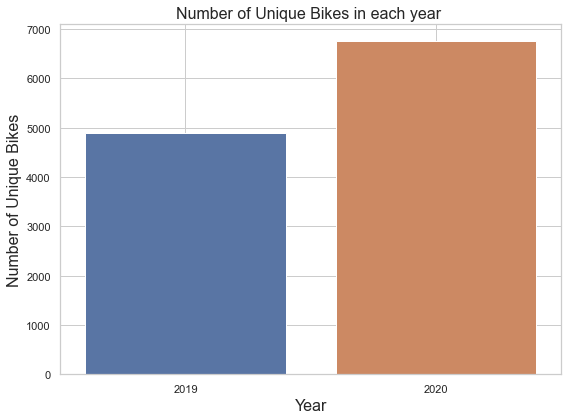

In [74]:
plt.figure(figsize =(8,6))
plt.title('Number of Unique Bikes in each year ', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.barplot(x = "Year", y="unique_Bikes",  data = df_bikes_year)
plt.grid(True)
plt.xlabel('Year',  fontsize = 16)
plt.ylabel('Number of Unique Bikes',  fontsize = 16);
# plt.legend( fontsize = 16);
plt.show();

The data corresponds to the bikeshare Toronto published data where the program reported 
5,000 bikes by end of 2019
and with an expansion reaching
6,850 bikes by end of 2020
Source for 2020: https://www.toronto.ca/legdocs/mmis/2021/pa/bgrd/backgroundfile-166730.pdf
Source for 2019: https://bikesharetoronto.com/news/2019-milestones/#:~:text=and%20Kingston%20Road!-,System%20Growth,make%20biking%20more%20accessible%20citywide.


Using the bike Id, the number of trips on each ride was calculated


In [73]:
df_bike_rides_number = df_subID[["Start_Time" , "Duration", "Year", "Bike Id"]].groupby(
    ["Bike Id", "Year"]).count()["Duration"].reset_index().rename(
    columns={"Duration":"number_rides"}).sort_values(by="number_rides", ascending = False)
df_bike_rides_number.head()



,Bike Id,Year,number_rides
10680,3732.0,2019,1003
16288,5964.0,2021,973
8876,3110.0,2019,970
15840,5738.0,2021,968
10593,3702.0,2019,967


In [76]:
df_bike_rides_number21 = Sub2019_2020_21[["Start_Time" , "Duration", "Year", "Bike Id"]].groupby(
    ["Bike Id", "Year"]).count()["Duration"].reset_index().rename(
    columns={"Duration":"number_rides"}).sort_values(by="number_rides", ascending = False)

df_bike_rides_number21.head(3)

,Bike Id,Year,number_rides
10680,3732.0,2019,1003
16288,5964.0,2021,973
8876,3110.0,2019,970


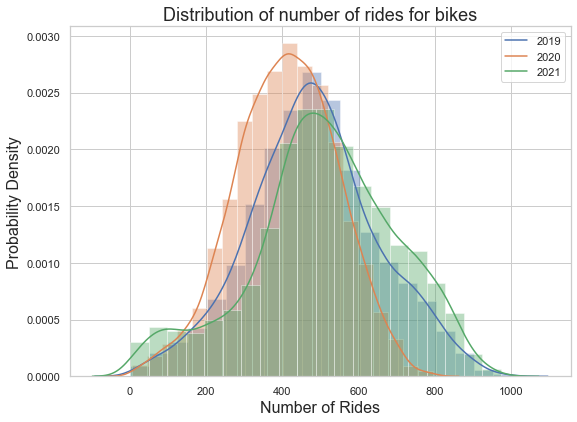

In [78]:
Sub2019_2020_21

# plot the number of trips per bike

plt.figure(figsize =(8,6))
plt.title('Distribution of number of rides for bikes', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_bike_rides_number21[df_bike_rides_number21["Year"] == 2019 ]["number_rides"], rug=False, bins = 20)
ax = sns.distplot(df_bike_rides_number21[df_bike_rides_number21["Year"] == 2020 ]["number_rides"], rug=False, bins = 20)
ax = sns.distplot(df_bike_rides_number21[df_bike_rides_number21["Year"] == 2021 ]["number_rides"], rug=False, bins = 20)

plt.xlabel('Number of Rides',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
# plt.xlim([0,365])
# plt.ylim([0,0.025]);
plt.legend(["2019", "2020", "2021"])
plt.show();


In [81]:
df_bike_rides_duration21 = Sub2019_2020_21[["Start_Time" , "Duration", "Year", "Bike Id"]].groupby(
    ["Bike Id", "Year"]).sum()["Duration"].reset_index().rename(
    columns={"Duration":"Rides_Duration"}).sort_values(by="Rides_Duration", ascending = False)
df_bike_rides_duration21.head()

,Bike Id,Year,Rides_Duration
17887,6781.0,2021,913632
17945,6813.0,2021,898233
17879,6777.0,2021,852334
16288,5964.0,2021,844015
15840,5738.0,2021,816051


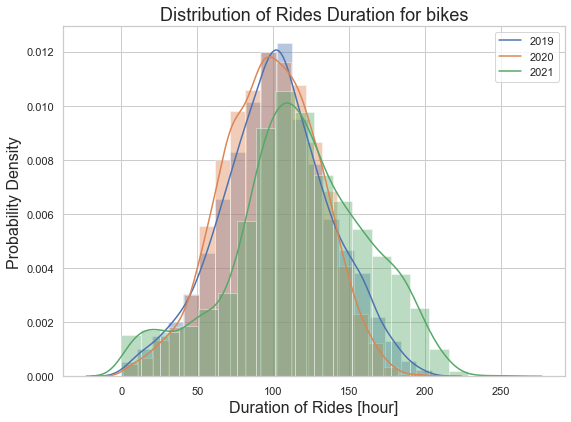

In [82]:
plt.figure(figsize =(8,6))
plt.title('Distribution of Rides Duration for bikes', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_bike_rides_duration21[df_bike_rides_duration21["Year"] == 2019 ]["Rides_Duration"] / 3600, rug=False, bins = 20)
ax = sns.distplot(df_bike_rides_duration21[df_bike_rides_duration21["Year"] == 2020 ]["Rides_Duration"] / 3600, rug=False, bins = 20)
ax = sns.distplot(df_bike_rides_duration21[df_bike_rides_duration21["Year"] == 2021 ]["Rides_Duration"] / 3600, rug=False, bins = 20)

plt.xlabel('Duration of Rides [hour]',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
# plt.xlim(|[0,365])
# plt.ylim([0,0.025]);
plt.legend(["2019", "2020", 2021])
plt.show();

Another look at the duration of each trip will give show the total duration used for each bike

In [77]:
df_bike_rides_duration = df_subID[["Start_Time" , "Duration", "Year", "Bike Id"]].groupby(
    ["Bike Id", "Year"]).sum()["Duration"].reset_index().rename(
    columns={"Duration":"Rides_Duration"}).sort_values(by="Rides_Duration", ascending = False)
df_bike_rides_duration.head()

,Bike Id,Year,Rides_Duration
7195,3702,2019,736050
5585,2883,2019,729906
11374,6627,2020,729208
11422,6675,2020,714956
7254,3732,2019,713537


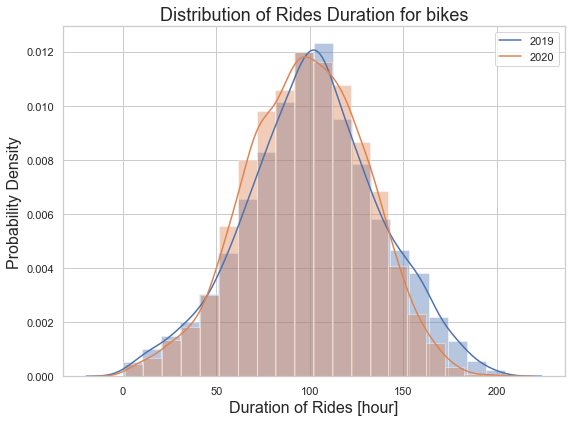

In [78]:
plt.figure(figsize =(8,6))
plt.title('Distribution of Rides Duration for bikes', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_bike_rides_duration[df_bike_rides_duration["Year"] == 2019 ]["Rides_Duration"] / 3600, rug=False, bins = 20)
ax = sns.distplot(df_bike_rides_duration[df_bike_rides_duration["Year"] == 2020 ]["Rides_Duration"] / 3600, rug=False, bins = 20)

plt.xlabel('Duration of Rides [hour]',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
# plt.xlim(|[0,365])
# plt.ylim([0,0.025]);
plt.legend(["2019", "2020"])
plt.show();

This shows that most bikes 

In [79]:
df_subID.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5130149 entries, 3236697 to 8366845
Data columns (total 15 columns):
 #   Column              Dtype                                 
---  ------              -----                                 
 0   ID                  int64                                 
 1   Start_Time          datetime64[ns, pytz.FixedOffset(-300)]
 2   End_Time            datetime64[ns, pytz.FixedOffset(-300)]
 3   Duration            int64                                 
 4   Start_Station_id    float64                               
 5   Start_Station_name  object                                
 6   End_Station_id      Int64                                 
 7   End_Station_name    object                                
 8   User_Type           object                                
 9   Subscription Id     Int64                                 
 10  Bike Id             Int64                                 
 11  Year                int64                   

In [82]:
df_subID_annual_ride_2019 = df_subID[["User_Type", "Subscription Id"]][
    (df_subID["Start_Time"].dt.year == 2019) & (df_subID["User_Type"] == "Annual")].groupby(
    "Subscription Id").count().sort_values(by="User_Type", ascending = False)
df_subID_annual_ride_2020 = df_subID[["User_Type", "Subscription Id"]][
    (df_subID["Start_Time"].dt.year == 2020) & (df_subID["User_Type"] == "Annual")].groupby(
    "Subscription Id").count().sort_values(by="User_Type", ascending = False)

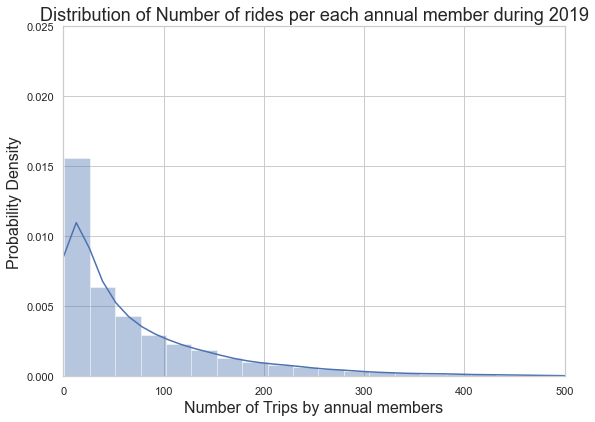

In [87]:
plt.figure(figsize =(8,6))
plt.title('Distribution of Number of rides per each annual member during 2019', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_subID_annual_ride_2019["User_Type"], rug=False, bins = 100)

plt.xlabel('Number of Trips by annual members',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
plt.xlim([0,500])
plt.ylim([0,0.025]);

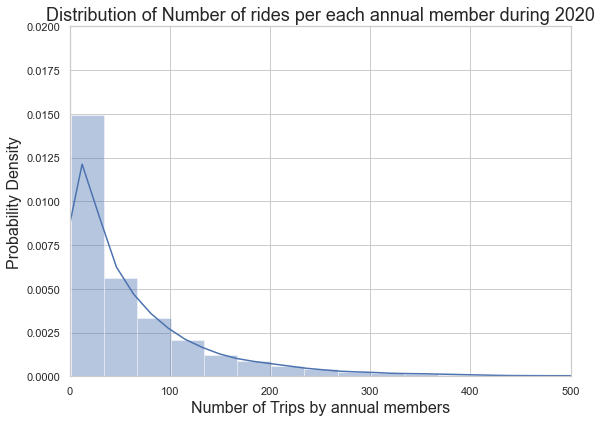

In [89]:
plt.figure(figsize =(8,6))
plt.title('Distribution of Number of rides per each annual member during 2020', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_subID_annual_ride_2020["User_Type"], rug=False, bins = 100)

plt.xlabel('Number of Trips by annual members',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
plt.xlim([0,500])
plt.ylim([0,0.02]);

In [92]:
df_subID_casual_time_2019 = df_subID[["User_Type", "Subscription Id", "Duration"]][
    (df_subID["Start_Time"].dt.year == 2019) & (df_subID["User_Type"] == "Casual")].groupby(
    "Subscription Id").sum().sort_values(by="Duration", ascending = False)
df_subID_casual_time_2020 = df_subID[["User_Type", "Subscription Id", "Duration"]][
    (df_subID["Start_Time"].dt.year == 2020) & (df_subID["User_Type"] == "Casual")].groupby(
    "Subscription Id").sum().sort_values(by="Duration", ascending = False)




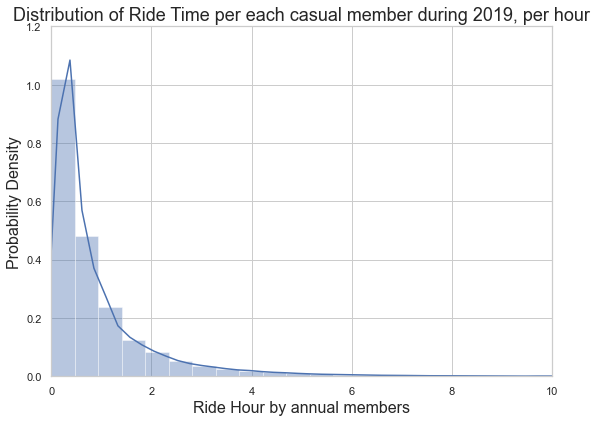

In [101]:
plt.figure(figsize =(8,6))
plt.title('Distribution of Ride Time per each casual member during 2019, per hour', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_subID_casual_time_2019["Duration"] / 3600 , rug=False, bins = 100)

plt.xlabel('Ride Hour by annual members',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
plt.xlim([0,10])
plt.ylim([0,1.2]);

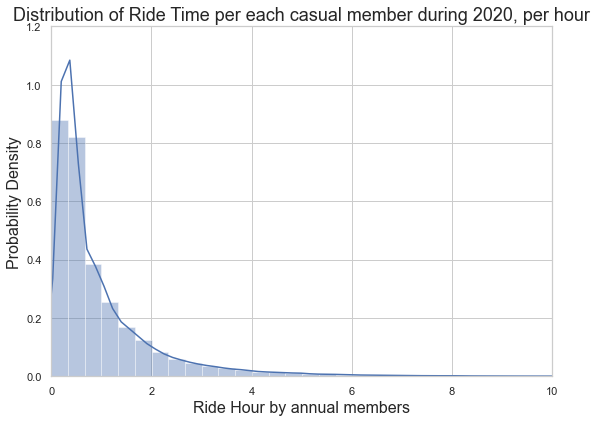

In [102]:
plt.figure(figsize =(8,6))
plt.title('Distribution of Ride Time per each casual member during 2020, per hour', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_subID_casual_time_2020["Duration"] / 3600 , rug=False, bins = 100)

plt.xlabel('Ride Hour by annual members',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )
plt.xlim([0,10])
plt.ylim([0,1.2]);

### Trip duration (30 minutes limit)

To address user's concerns with respect to the 30-minute trip length, we will analyze the behaviour between casual and annual members

In [103]:
#Let's estimate the ratio of annual trips to all trips
counter = bikerides_df[["Start_Time","User_Type"]].groupby("User_Type").count()
ratio_Annual_to_All_Trips = counter.iloc[0,0]/(counter.iloc[1,0]+counter.iloc[0,0])
print("The ratio of Annual trips to all trips is {:.2f}".format(ratio_Annual_to_All_Trips))

The ratio of Annual trips to all trips is 0.72


In [104]:
# create a sub dataframe filtering Casual and Annual members only
df_casual = bikerides_df[(bikerides_df["User_Type"] == "Casual")]
df_annual = bikerides_df[bikerides_df["User_Type"] == "Annual"]
print(df_casual.shape)
print(df_annual.shape)

(3251133, 11)
(8410024, 11)


In [105]:
# filtering for more than 30 minutes
df_casual_more_30 = df_casual[df_casual["Duration"] >= 1800]
df_annual_more_30 = df_annual[df_annual["Duration"] >= 1800]

print(df_casual_more_30.shape)
print(df_annual_more_30.shape)

(216017, 11)
(97609, 11)


In [106]:
# filtering for less than 30 minutes
df_casual_less_30 = df_casual[df_casual["Duration"] < 1800]
df_annual_less_30 = df_annual[df_annual["Duration"] < 1800]

print(df_casual_less_30.shape)
print(df_casual_less_30.shape)

(3035116, 11)
(3035116, 11)


Text(0, 0.5, 'Probability Density')

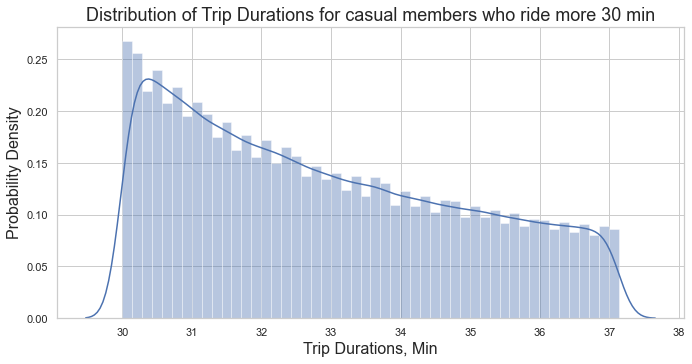

In [107]:
plt.figure(figsize =(10,5))
plt.title('Distribution of Trip Durations for casual members who ride more 30 min', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_casual_more_30["Duration"] / 60 , rug=False)

plt.xlabel('Trip Durations, Min',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )


Text(0, 0.5, 'Probability Density')

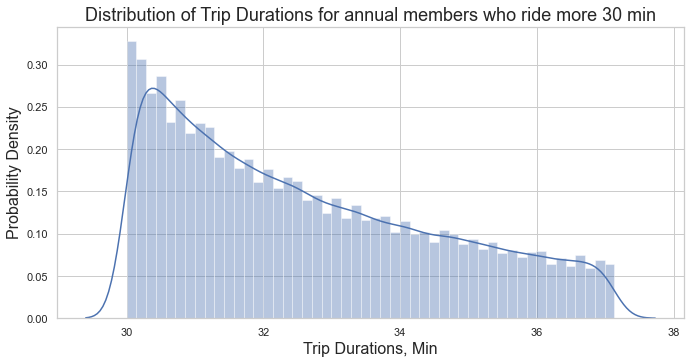

In [108]:
plt.figure(figsize =(10,5))
plt.title('Distribution of Trip Durations for annual members who ride more 30 min', fontsize = 18)
sns.set_theme(style="whitegrid")
ax = sns.distplot(df_annual_more_30["Duration"] / 60 , rug=False)

plt.xlabel('Trip Durations, Min',  fontsize = 16 )
plt.ylabel('Probability Density',  fontsize = 16 )

## what does this say?? fill here ^

In order to see where these commuters are coming from, let's analyze the most commonly originating stations

Text(0.5, 1.0, 'Top Destination Station (Annual Members)')

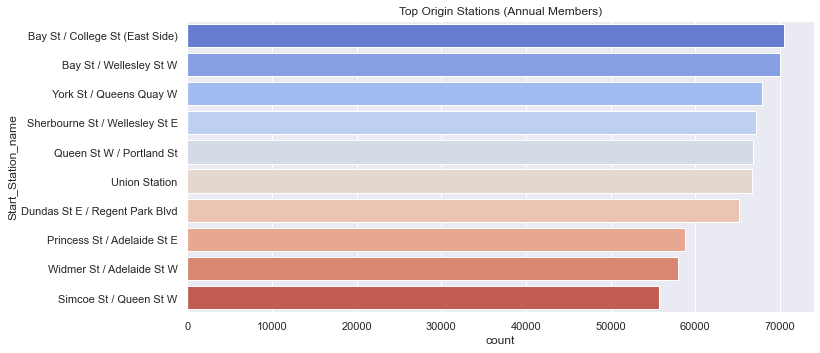

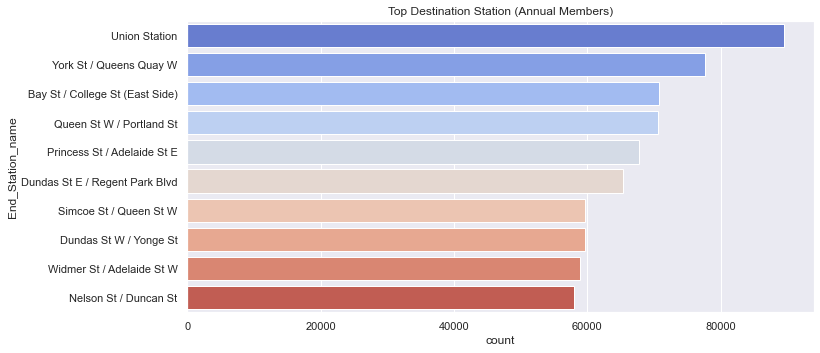

In [135]:
#Annual Members
#top 10 originating stations 
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(y=bikerides_df[bikerides_df['User_Type']=='Annual']['Start_Station_name'],data=bikerides_df, palette='coolwarm',order=bikerides_df[bikerides_df['User_Type']=='Annual']['Start_Station_name'].value_counts().index[:10])
plt.title('Top Origin Stations (Annual Members)')

#top 10 destination stations

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(y=bikerides_df[bikerides_df['User_Type']=='Annual']['End_Station_name'],data=bikerides_df, palette='coolwarm',order=bikerides_df[bikerides_df['User_Type']=='Annual']['End_Station_name'].value_counts().index[:10])
plt.title('Top Destination Station (Annual Members)')

Text(0.5, 1.0, 'Top Destination Station (Casual Members)')

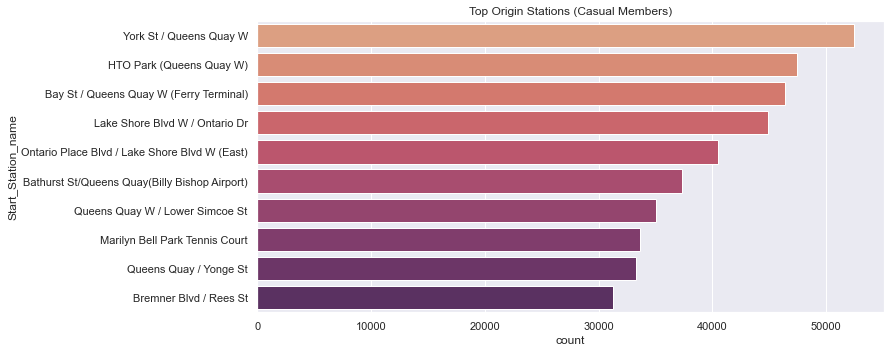

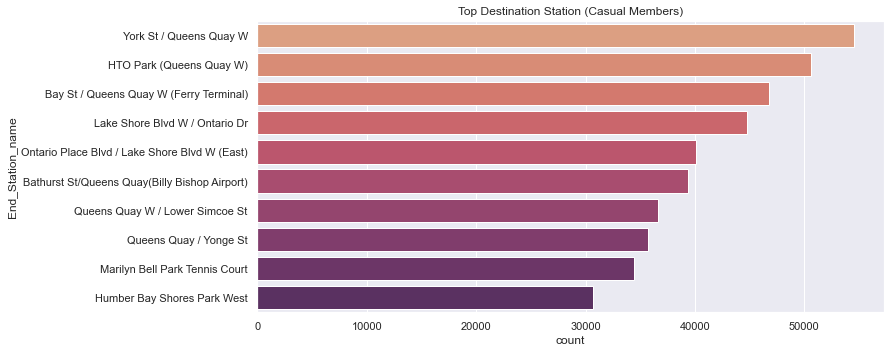

In [136]:
#Casual Members
#top 10 originating stations 
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(y=bikerides_df[bikerides_df['User_Type']=='Casual']['Start_Station_name'],data=bikerides_df, palette='flare',order=bikerides_df[bikerides_df['User_Type']=='Casual']['Start_Station_name'].value_counts().index[:10])
plt.title('Top Origin Stations (Casual Members)')

#top 10 destination stations

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(y=bikerides_df[bikerides_df['User_Type']=='Casual']['End_Station_name'],data=bikerides_df, palette='flare',order=bikerides_df[bikerides_df['User_Type']=='Casual']['End_Station_name'].value_counts().index[:10])
plt.title('Top Destination Station (Casual Members)')

In [80]:
#Casual Members
#top 10 originating stations 
plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(y=bikerides_df['Start_Station_name'], data=bikerides_df, palette='flare',order=bikerides_df['Start_Station_name'].value_counts().index[:10])
plt.title('Top Origin Stations (Casual Members)')

#top 10 destination stations

plt.figure(figsize=(10,5))
sns.set_style('darkgrid')
sns.countplot(y=bikerides_df[['End_Station_name'],data=bikerides_df, palette='flare',order=bikerides_df['End_Station_name'].value_counts().index[:10])
plt.title('Top Destination Station (Casual Members)')

SyntaxError: invalid syntax (Temp/ipykernel_11228/2727779359.py, line 12)

### Weather 

After seeing the ridership by user type, times and through stations, lets visualize the effects of weather on ridership

In [137]:
bikerides_df.head(2)

,ID,Start_Time,End_Time,Duration,Start_Station_id,Start_Station_name,End_Station_id,End_Station_name,User_Type,Subscription Id,Bike Id
0,712441,2017-01-01 00:03:00-05:00,2017-01-01 00:08:00-05:00,274,7006.0,Bay St / College St (East Side),7021.0,Bay St / Albert St,Annual,NaN,NaN
1,712442,2017-01-01 00:03:00-05:00,2017-01-01 00:12:00-05:00,538,7046.0,Niagara St / Richmond St W,7147.0,King St W / Fraser Ave,Annual,NaN,NaN


In [138]:
#Counting the number of rides: 
count_rides = bikerides_df[['Start_Time' , 'User_Type']]
count_rides =count_rides.set_index(['Start_Time']).groupby('User_Type').resample('h').count(
).rename(columns = {'User_Type' : 'Count'}).reset_index('User_Type')

count_rides

,User_Type,Count
Start_Time,,
2016-12-31 20:00:00-05:00,Annual,19
2016-12-31 21:00:00-05:00,Annual,13
2016-12-31 22:00:00-05:00,Annual,10
2016-12-31 23:00:00-05:00,Annual,15
2017-01-01 00:00:00-05:00,Annual,16
...,...,...
2021-12-11 19:00:00-05:00,Casual,358
2021-12-11 20:00:00-05:00,Casual,174
2021-12-11 21:00:00-05:00,Casual,178


In [139]:
count_rides.isnull().sum()

User_Type    0
Count        0
dtype: int64

In [140]:
#Merging Annual and Casual counts:
count_rides = count_rides[count_rides['User_Type'] == 'Annual'].merge(
    count_rides[count_rides['User_Type'] == 'Casual'], how = 'inner', on='Start_Time').rename(
    columns={"Count_x": "Annual Member", "Count_y": "Casual Member"}).drop(
    columns=['User_Type_x', 'User_Type_y'])

count_rides['rides'] = count_rides['Annual Member'] + count_rides['Casual Member']

count_rides

,Annual Member,Casual Member,rides
Start_Time,,,
2016-12-31 21:00:00-05:00,13,1,14
2016-12-31 22:00:00-05:00,10,0,10
2016-12-31 23:00:00-05:00,15,0,15
2017-01-01 00:00:00-05:00,16,2,18
2017-01-01 01:00:00-05:00,13,0,13
...,...,...,...
2021-12-11 19:00:00-05:00,218,358,576
2021-12-11 20:00:00-05:00,106,174,280
2021-12-11 21:00:00-05:00,104,178,282


In [141]:
weather_df = weather_df.set_index('Date/Time')


In [142]:
hourly_ride_weather = count_rides.merge(weather_df[['Weather', 'Temp (°C)']], left_index=True, right_index=True)
hourly_ride_weather.shape

(43344, 5)

In [143]:
hourly_ride_weather.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 43344 entries, 2017-01-01 00:00:00-05:00 to 2021-12-11 23:00:00-05:00
Freq: H
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Annual Member  43344 non-null  int64  
 1   Casual Member  43344 non-null  int64  
 2   rides          43344 non-null  int64  
 3   Weather        43344 non-null  object 
 4   Temp (°C)      43195 non-null  float64
dtypes: float64(1), int64(3), object(1)
memory usage: 2.0+ MB


Now we change the data from hour to the day and add workdays to the dataframe

In [144]:
daily_data_rides = hourly_ride_weather[['Annual Member','Casual Member']].resample('d').sum()
daily_data_rides['rides'] = hourly_ride_weather.resample('d')['rides'].sum()

workday = []
for i in range(daily_data_rides.shape[0]):
    if daily_data_rides.index[i].weekday() < 5:
        is_workday = True
    else:
        is_workday = False
    workday.append(is_workday)
    
daily_data_rides['Workday'] = workday

#Calculating the mean of Tempreture per day
daily_data_rides['Temp (°C)'] = hourly_ride_weather.resample('d')['Temp (°C)'].mean()

daily_data_rides

,Annual Member,Casual Member,rides,Workday,Temp (°C)
2017-01-01 00:00:00-05:00,412,70,482,False,1.400000
2017-01-02 00:00:00-05:00,756,70,826,True,2.854167
2017-01-03 00:00:00-05:00,853,18,871,True,4.254167
2017-01-04 00:00:00-05:00,1361,34,1395,True,-0.975000
2017-01-05 00:00:00-05:00,1191,19,1210,True,-6.816667
...,...,...,...,...,...
2021-12-07 00:00:00-05:00,9712,3054,12766,True,-2.316667
2021-12-08 00:00:00-05:00,9762,4217,13979,True,-3.000000
2021-12-09 00:00:00-05:00,7952,5043,12995,True,-1.716667
2021-12-10 00:00:00-05:00,5459,8915,14374,True,3.879167


#### How workdays impact number of rides?

Text(0, 0.5, 'Annual Member')

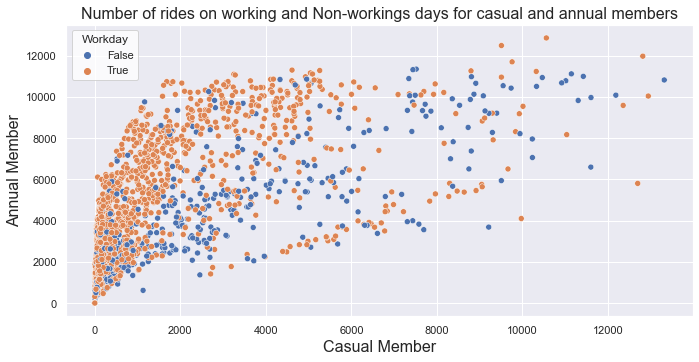

In [145]:
plt.figure(figsize =(10,5))
plt.title('Number of rides on working and Non-workings days for casual and annual members', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(data = daily_data_rides, x='Casual Member', y="Annual Member", hue="Workday")
plt.xlabel('Casual Member',  fontsize = 16 )
plt.ylabel('Annual Member',  fontsize = 16 )


We've already seen that while annual members use bikes throughout the workdays more, the casual members rides increases at the weekends.
for casual members, there is a clear trend for higher weekend usage and could well continue into the next years.

Let's creare a Violin plot for all number of rides

Text(0.5, 1.0, 'total number of rides')

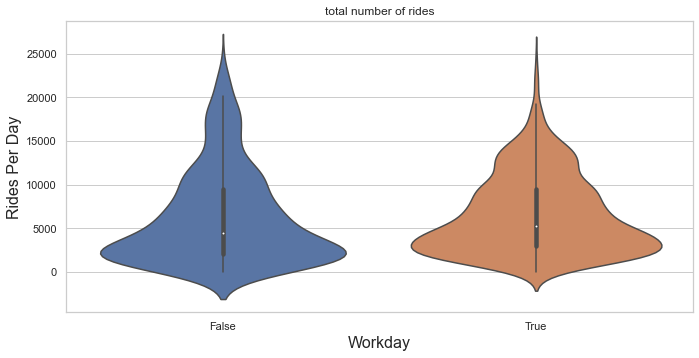

In [146]:
plt.figure(figsize =(10,5))
sns.set_theme(style="whitegrid")

ax = sns.violinplot(data = daily_data_rides, x = 'Workday' , y = 'rides')
plt.xlabel('Workday',fontsize = 16 )
plt.ylabel('Rides Per Day', fontsize = 16 )
plt.title('total number of rides')

Text(0, 0.5, 'Annual member Rides Per Day')

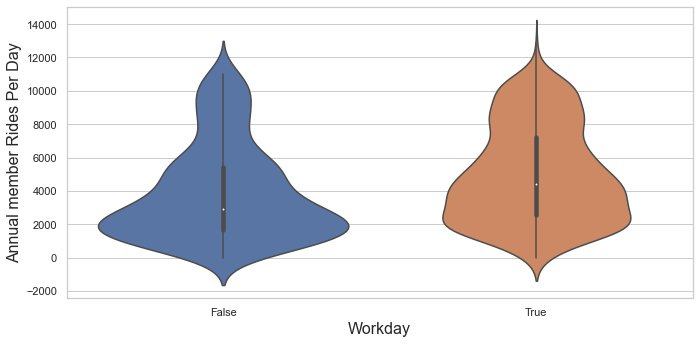

In [147]:
#Violin plot for annual member rides:
plt.figure(figsize =(10,5))
sns.set_theme(style="whitegrid")

ax = sns.violinplot(data = daily_data_rides, x = 'Workday' , y = 'Annual Member')
plt.xlabel('Workday',fontsize = 16 )
plt.ylabel('Annual member Rides Per Day', fontsize = 16 )

Text(0, 0.5, 'Casual member Rides Per Day')

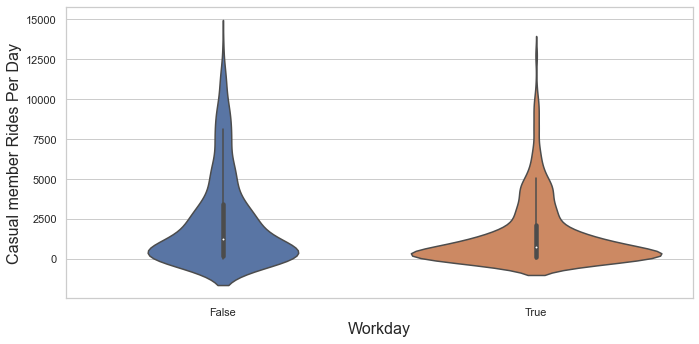

In [148]:
# Violin plot for casual member rides:
plt.figure(figsize =(10,5))
sns.set_theme(style="whitegrid")

ax = sns.violinplot(data = daily_data_rides, x = 'Workday' , y = 'Casual Member')
plt.xlabel('Workday',fontsize = 16 )
plt.ylabel('Casual member Rides Per Day', fontsize = 16 )

We observe that casual members has less affect on overall rides, yet wider range of use for weekends.

OBSERVATION: Annual members were observed to use the service more often during weekdays, while more casual riders used the service during the weekends. In line with the prior observation of members possibly using the trips for commute to or from work, it was further noticed that the ridership by annual members was higher during the weekdays. The casual riders on the other hand were observed to make more trips during the weekends, indicating possible usage by families and tourists to explore the area. This also corroborates with the shorter average trip duration for annual members vs longer duration for casual riders. 

#### weather's impact on number of rides

In [149]:
# count the number of weather types
weather_df['Weather'].value_counts()

Clear                              37057
Rain                                2154
Snow                                1737
Fog                                 1430
Rain,Fog                             925
Haze                                 170
Moderate Rain,Fog                     97
Thunderstorms,Rain                    50
Moderate Rain                         42
Rain,Snow                             26
Thunderstorms                         25
Heavy Rain,Fog                        16
Moderate Snow                         16
Thunderstorms,Moderate Rain           12
Freezing Rain,Fog                     11
Thunderstorms,Heavy Rain,Fog          11
Heavy Snow                             7
Thunderstorms,Rain,Fog                 7
Thunderstorms,Moderate Rain,Fog        7
Freezing Rain                          5
Snow,Blowing Snow                      5
Freezing Rain,Snow                     4
Thunderstorms,Heavy Rain               4
Haze,Blowing Snow                      3
Thunderstorms,Fo

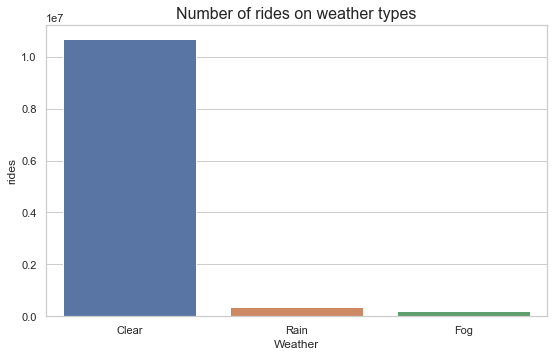

In [150]:
temp_df = hourly_ride_weather.groupby(['Weather']).sum().sort_values(by='rides', ascending = False).drop(
    columns={'Temp (°C)'}).reset_index()

plt.figure(figsize=(8,5))
plt.title('Number of rides on weather types', fontsize = 16)

ax= sns.barplot( x = temp_df["Weather"][0:3], y=temp_df["rides"][0:3])
plt.show()

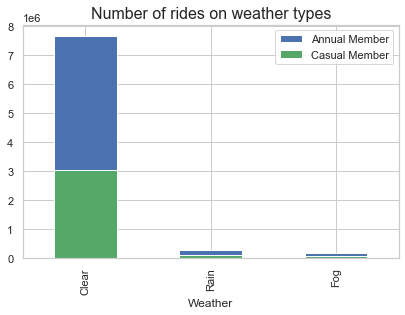

In [151]:
ax = temp_df[0:3].plot(x="Weather", y="Annual Member", kind="bar")
plt.title('Number of rides on weather types', fontsize = 16)
temp_df[0:3].plot(x="Weather", y="Casual Member", kind="bar", ax=ax, color="C2")

plt.show()

Text(0, 0.5, 'ANumber of rides')

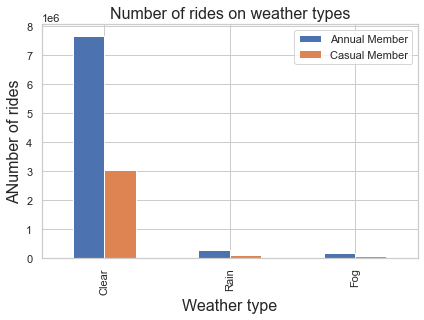

In [152]:
temp_compare = temp_df.loc[0:2]

temp_compare.plot(x= 'Weather', y=["Annual Member", "Casual Member"], kind="bar")
plt.title('Number of rides on weather types', fontsize = 16)

plt.xlabel('Weather type',fontsize = 16 )
plt.ylabel('ANumber of rides', fontsize = 16)

OBSERVATION: 
While majority of rides happen when there are no weather events (Clear weather type), rain seems the most common for riders to ride in compared to other events. Snow and fog weather conditions still have some amount of rides.

#### Further, let's compare the number of rides in clear and rain weather

For this purpose, "Clear" and "Rain" hours are extracted and resampled by day to compare number of rides in "clear hours of day" with number of rides in "Rain hours of day"

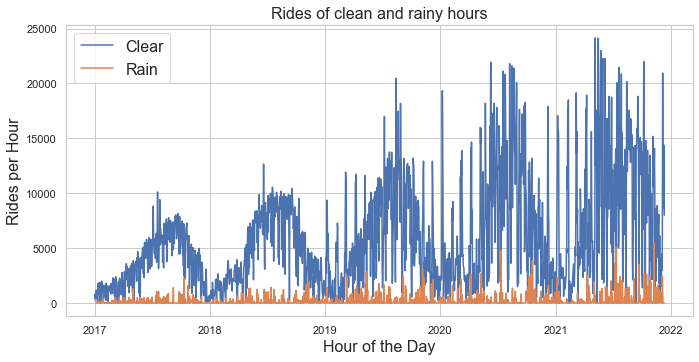

In [153]:
clear_hr_ofDay = hourly_ride_weather.loc[hourly_ride_weather['Weather']=='Clear'].resample('d').sum()
rain_hr_ofDay = hourly_ride_weather.loc[hourly_ride_weather['Weather']=='Rain'].resample('d').sum()

plt.figure(figsize =(10,5))
plt.title('Rides of clean and rainy hours', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = clear_hr_ofDay.index, y = clear_hr_ofDay["rides"])
ax = sns.lineplot(x = rain_hr_ofDay.index, y = rain_hr_ofDay["rides"])
plt.xlabel('Hour of the Day',  fontsize = 16)
plt.ylabel('Rides per Hour', fontsize = 16)
#plt.xlim(0,24)
#plt.ylim(0,655)
plt.legend(['Clear', 'Rain'],  fontsize = 16)

For this purpose, "Clear" and "Rain" hours are extracted and resampled by week to compare number of rides in "clear hours of week" with number of rides in "Rain hours of week"

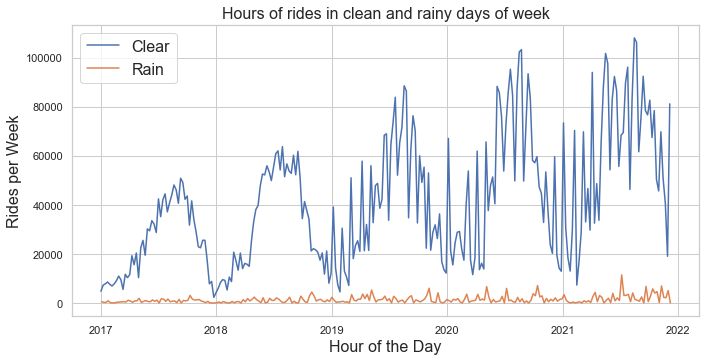

In [154]:
clear_hr_ofweek = hourly_ride_weather.loc[hourly_ride_weather['Weather']=='Clear'].resample('7d').sum()
rain_hr_ofweek = hourly_ride_weather.loc[hourly_ride_weather['Weather']=='Rain'].resample('7d').sum()

plt.figure(figsize =(10,5))
plt.title('Hours of rides in clean and rainy days of week', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = clear_hr_ofweek.index, y = clear_hr_ofweek["rides"])
ax = sns.lineplot(x = rain_hr_ofweek.index, y = rain_hr_ofweek["rides"])
plt.xlabel('Hour of the Day',  fontsize = 16)
plt.ylabel('Rides per Week', fontsize = 16)
#plt.xlim(0,24)
#plt.ylim(0,655)
plt.legend(['Clear', 'Rain'],  fontsize = 16)

#### Tempratures's impact on the rides


An average daily tempreture could be a fiar factor for this comparison.

Text(0, 0.5, 'Rides per day')

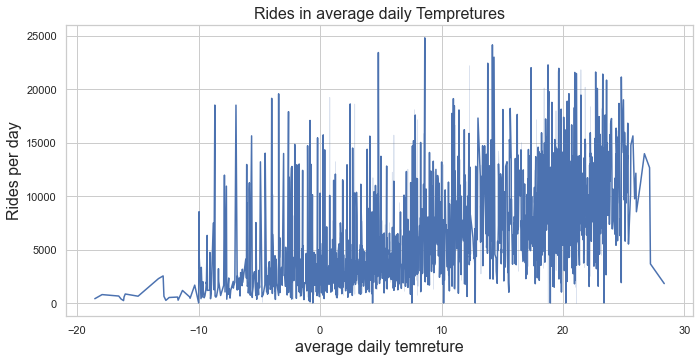

In [155]:
#total number of rides
plt.figure(figsize =(10,5))
plt.title('Rides in average daily Tempretures', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = daily_data_rides['Temp (°C)'], y = daily_data_rides["rides"])
plt.xlabel('average daily temreture',  fontsize = 16)
plt.ylabel('Rides per day', fontsize = 16)

Text(0, 0.5, 'Rides per week')

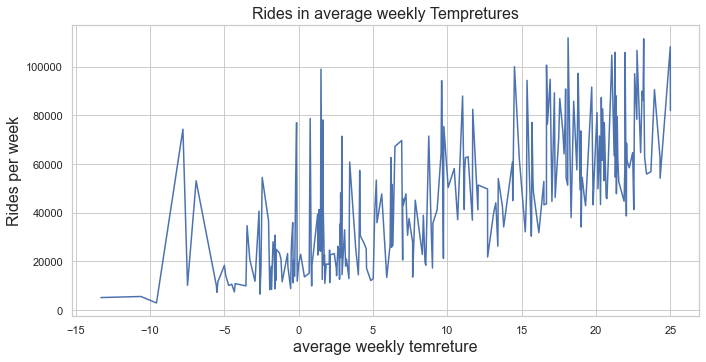

In [156]:
#weekly rides

plt.figure(figsize =(10,5))
plt.title('Rides in average weekly Tempretures', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = daily_data_rides.resample('7d')['Temp (°C)'].mean(), y = daily_data_rides.resample('7d')["rides"].sum())
plt.xlabel('average weekly temreture',  fontsize = 16)
plt.ylabel('Rides per week', fontsize = 16)

#### We can also compare annual and casual rides separately:

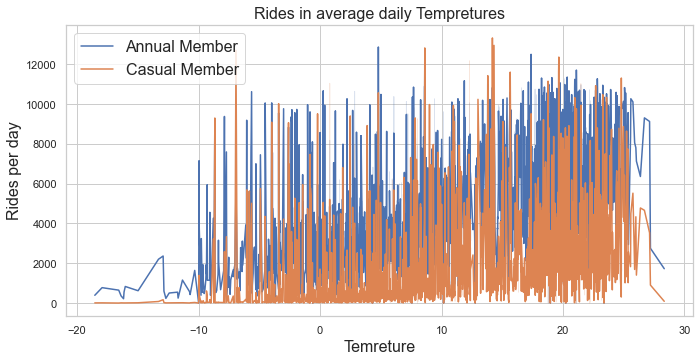

In [157]:
plt.figure(figsize =(10,5))
plt.title('Rides in average daily Tempretures', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = daily_data_rides['Temp (°C)'], y = daily_data_rides["Annual Member"])
ax = sns.lineplot(x = daily_data_rides['Temp (°C)'], y = daily_data_rides["Casual Member"])
plt.xlabel('Temreture',  fontsize = 16)
plt.ylabel('Rides per day', fontsize = 16)

plt.legend(['Annual Member', 'Casual Member'],  fontsize = 16)

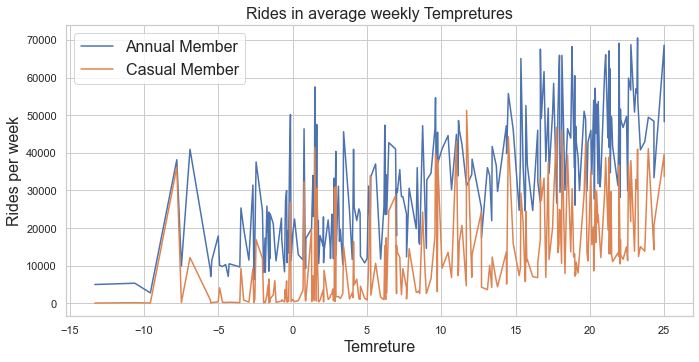

In [158]:
plt.figure(figsize =(10,5))
plt.title('Rides in average weekly Tempretures', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = daily_data_rides.resample('7d')['Temp (°C)'].mean(), y = daily_data_rides.resample('7d')["Annual Member"].sum())
ax = sns.lineplot(x = daily_data_rides.resample('7d')['Temp (°C)'].mean(), y = daily_data_rides.resample('7d')["Casual Member"].sum())
plt.xlabel('Temreture',  fontsize = 16)
plt.ylabel('Rides per week', fontsize = 16)

plt.legend(['Annual Member', 'Casual Member'],  fontsize = 16)

NameError: name 'daily_data_rides' is not defined

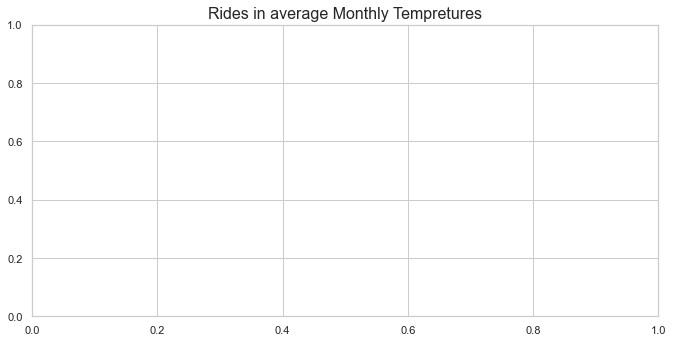

In [73]:
plt.figure(figsize =(10,5))
plt.title('Rides in average Monthly Tempretures', fontsize = 16)
sns.set_theme(style="whitegrid")

ax = sns.lineplot(x = daily_data_rides.resample('m')['Temp (°C)'].mean(), y = daily_data_rides.resample('m')["Annual Member"].sum())
ax = sns.lineplot(x = daily_data_rides.resample('m')['Temp (°C)'].mean(), y = daily_data_rides.resample('m')["Casual Member"].sum())
plt.xlabel('Temperature',  fontsize = 16)
plt.ylabel('Rides per month', fontsize = 16)

plt.legend(['Annual Member', 'Casual Member'],  fontsize = 16)

OBSERVATION:
we can find some ranges of tempretures that are more popular among riders.

###### Scatterplot:

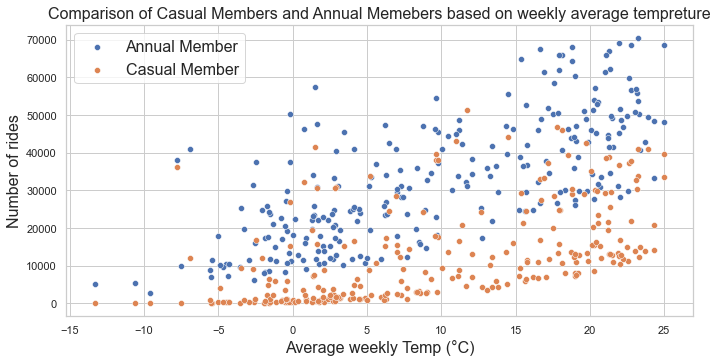

In [160]:
plt.figure(figsize =(10,5))
plt.title('Comparison of Casual Members and Annual Memebers based on weekly average tempreture', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x = daily_data_rides.resample('7d')['Temp (°C)'].mean(), y=daily_data_rides.resample('7d')['Annual Member'].sum())
ax = sns.scatterplot(x = daily_data_rides.resample('7d')['Temp (°C)'].mean(), y=daily_data_rides.resample('7d')['Casual Member'].sum())

plt.xlabel('Average weekly Temp (°C)',  fontsize = 16 )
plt.ylabel('Number of rides',  fontsize = 16 )
plt.legend(['Annual Member','Casual Member'] , fontsize = 16 )

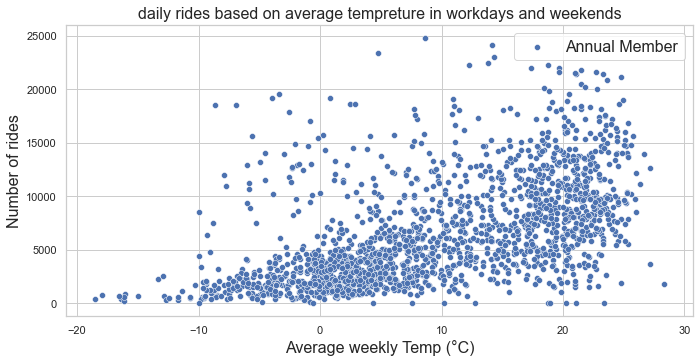

In [161]:
plt.figure(figsize =(10,5))
plt.title('daily rides based on average tempreture in workdays and weekends', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(x = daily_data_rides['Temp (°C)'] , y=daily_data_rides['rides'])
#ax = sns.scatterplot(x = daily_data_rides.resample('d')['Temp (°C)'].mean(), y=daily_data_rides.resample('7d')['Casual Member'].sum())

plt.xlabel('Average weekly Temp (°C)',  fontsize = 16 )
plt.ylabel('Number of rides',  fontsize = 16 )
plt.legend(['Annual Member','Casual Member'] , fontsize = 16 )

Text(0, 0.5, 'rides')

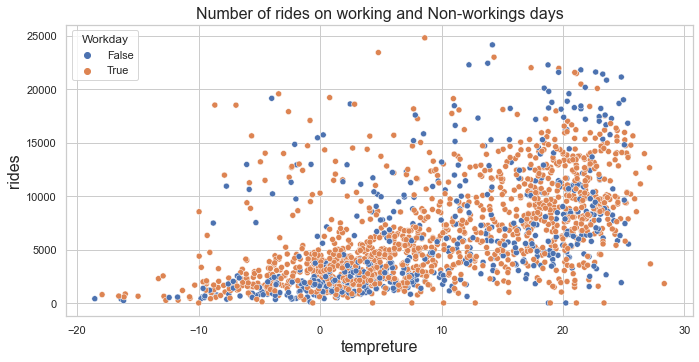

In [162]:
plt.figure(figsize =(10,5))
plt.title('Number of rides on working and Non-workings days', fontsize = 16)
sns.set_theme(style="whitegrid")
ax = sns.scatterplot(data = daily_data_rides, x='Temp (°C)', y="rides", hue="Workday")
plt.xlabel('tempreture',  fontsize = 16 )
plt.ylabel('rides',  fontsize = 16 )


#### Feature engineering and creating a model

Average tempreture, type of weather and weekday status are correlated with the number of rides. Now based on the described factors and their impact on the number of rides, we can choose two or three of them as features to create some machine learning models and then compare the models and their accuracy.